<center><img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px; margin-left: 10px; max-height: 250px;" /></center>

# 2.2 Data Discovery & Properties

## GDAL, STAC and Data Properties

In this exercise we interact with a SpatioTemporal Asset Catalog (STAC) and explore the metadata using GDAL.

Start importing the necessary libraries

In [1]:
from osgeo import gdal
from pystac_client import Client

import rasterio
import numpy as np
import matplotlib.pyplot as plt

### Exploring STAC Collections

Connect to a STAC API and explore available data collections.  

In [2]:
from pystac_client import Client

# Connect to a STAC API
catalog = Client.open("https://earth-search.aws.element84.com/v1")

# List available collections
collections = catalog.get_collections()
print("Available STAC Collections:")
for collection in collections:
    print(collection.id)

Available STAC Collections:
sentinel-2-pre-c1-l2a
cop-dem-glo-30
naip
cop-dem-glo-90
landsat-c2-l2
sentinel-2-l2a
sentinel-2-l1c
sentinel-2-c1-l2a
sentinel-1-grd


### Querying Sentinel-2 data from a STAC API

Connect to the same public STAC API and search for Sentinel-2 Level-2A products over a specific area (Sardinia) and time range (September 2023).  
We will filter the results to include only those items with less than or equal to 20% cloud cover.  
The code retrieves all matching items and prints the number of results, as well as the unique IDs of the returned items.  
This demonstrates how to query a geospatial data catalog programmatically using the `pystac-client` library- [which documentation can be found here](https://pystac-client.readthedocs.io/).


In [3]:
# Connect to a public STAC API (e.g., Sentinel-2)
catalog = Client.open("https://earth-search.aws.element84.com/v1")

# Search for Sentinel-2 items over a specific area and date range
items = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2023-09-01/2023-09-30",
    bbox=[8.0, 40.0, 9.0, 41.0],  # Example bounding box for Sardinia
    query={"eo:cloud_cover": {"lte": 20}}
).item_collection()

# Print the number of items found
print(f"Number of items found: {len(items)}\n")

# Display the IDs of the found items
print("List of Sentinel-2 ids:")
for item in items:
    print(item.id)

Number of items found: 22

List of Sentinel-2 ids:
S2A_32TNK_20230930_0_L2A
S2A_32TML_20230930_0_L2A
S2A_32TNL_20230930_0_L2A
S2B_32TNK_20230928_0_L2A
S2B_32TMK_20230925_0_L2A
S2B_32TMK_20230915_0_L2A
S2B_32TML_20230915_0_L2A
S2B_32TNL_20230915_0_L2A
S2A_32TMK_20230910_0_L2A
S2A_32TNK_20230910_0_L2A
S2A_32TNL_20230910_0_L2A
S2B_32TMK_20230908_0_L2A
S2B_32TNK_20230908_0_L2A
S2B_32TML_20230908_0_L2A
S2B_32TNL_20230908_0_L2A
S2B_32TMK_20230905_0_L2A
S2B_32TNK_20230905_0_L2A
S2B_32TML_20230905_0_L2A
S2B_32TNL_20230905_0_L2A
S2A_32TNK_20230903_0_L2A
S2A_32TML_20230903_0_L2A
S2A_32TNL_20230903_0_L2A


### Metadata exploration

Display some metadata of the first STAC Item returned by our previous query:

In [4]:
# Display metadata for the found items
print(f"ID: {items[0].id}")
print(f"Date: {items[0].datetime}")
print(f"Cloud Cover: {items[0].properties['eo:cloud_cover']}%")
print(f"Geometry: {items[0].geometry}")
print(f"Projection as EPSG Code: {items[0].properties['proj:epsg']}")

ID: S2A_32TNK_20230930_0_L2A
Date: 2023-09-30 10:19:46.535000+00:00
Cloud Cover: 0.000919%
Geometry: {'type': 'Polygon', 'coordinates': [[[8.999775264333298, 40.650847506566784], [8.99977850198158, 39.66161596790567], [10.279630591063311, 39.65456644304081], [10.298328663178303, 40.64354834012356], [8.999775264333298, 40.650847506566784]]]}
Projection as EPSG Code: 32632


### Accessing and inspecting a Sentinel-2 red band raster

Access the first Sentinel-2 item from a previously retrieved STAC search result and extract the URL for the red band.  
Using GDAL, we will open the raster file from this URL and inspect its metadata, including the raster size, coordinate reference system (CRS), and geotransform parameters.  
This demonstrates how to programmatically access specific assets within a STAC item and retrieve relevant geospatial metadata.

Inspect the structure of items, available assets and properties

In [5]:
items[0]

<Item id=S2A_32TNK_20230930_0_L2A>

Print the metadata using GDAL Python

In [6]:
first_item = items[0]

asset_red_href = first_item.assets['red'].href  # Assuming B04 (red band) is available

# Open and inspect the raster file
dataset = gdal.Open(asset_red_href)
print(f"Raster Size: {dataset.RasterXSize} x {dataset.RasterYSize}")
print(f"Projection: {dataset.GetProjection()}")
geotransform = dataset.GetGeoTransform()
print(f"GeoTransform: {dataset.GetGeoTransform()}")

# Get spatial resolution
pixel_width = geotransform[1]
pixel_height = geotransform[5]
print(f"Pixel Size: {pixel_width} x {pixel_height}")

# Get the number of bands
bands = dataset.RasterCount
print(f"Number of Bands: {bands}")

/home/conda/cubes-and-clouds/765d57f67fe772f2321ea6683d272080703a6fec17a9d7ed6b8cd6703f3cb4b6-20250408-094026-878903-578-pangeo/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Raster Size: 10980 x 10980
Projection: PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]
GeoTransform: (499980.0, 10.0, 0.0, 4500000.0, 0.0, -10.0)
Pixel Size: 10.0 x -10.0
Number of Bands: 1


Print the metadata using GDAL from command line

In [7]:
import os
os.system(f"gdalinfo {first_item.assets['red'].href}")

Driver: GTiff/GeoTIFF
Files: none associated
Size is 10980, 10980
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 32N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 32N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",9,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PAR

0

### Simple band visualization

Read the red band data as a NumPy array:

In [8]:
red_band = dataset.GetRasterBand(1).ReadAsArray()

Finally, visualize the content

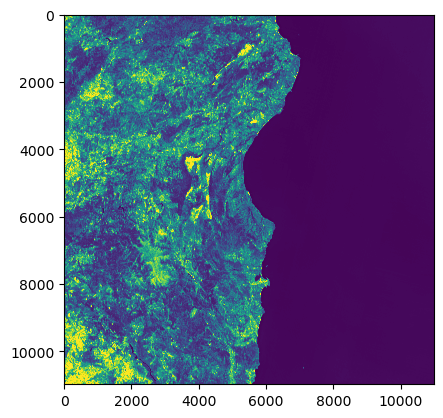

In [9]:
plt.imshow(red_band/1800,vmin=0,vmax=1)